In [1]:
from IPython.core.pylabtools import figsize
from PIL.Image import Image
from scipy.spatial.distance import jaccard
%matplotlib inline
import numpy as np
import torch
import torchvision
from torch import nn
import d2l

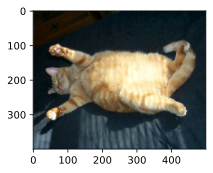

In [2]:
d2l.set_figsize()
img = d2l.Image.open("../img/cat1.jpg")
d2l.plt.imshow(img)

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

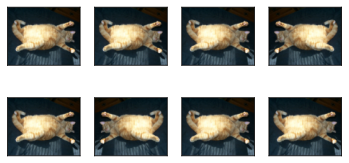

In [4]:
# 左右翻转图像通常不会改变对象的类别。这是最早且最广泛使用的图像增广方法之一。
# 随机翻转可以降低模型对镜像翻转的依赖。
apply(img, torchvision.transforms.RandomHorizontalFlip())

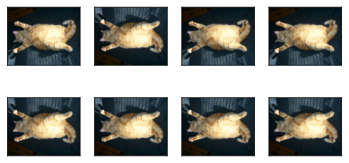

In [5]:
# 上下翻转
apply(img, torchvision.transforms.RandomVerticalFlip())

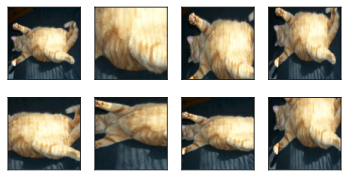

In [6]:
# 下面的代码将随机裁剪一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5～2之间随机取值。然
# 后，区域的宽度和高度都被缩放到200像素
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2)
)
apply(img, shape_aug)

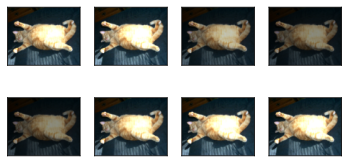

In [7]:
apply(img, torchvision.transforms.ColorJitter(
    # 分别对应亮度、对比度、饱和度、色调
    brightness=0.5, contrast=0, saturation=0, hue=0
))

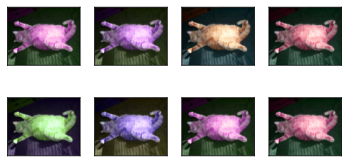

In [8]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5
))

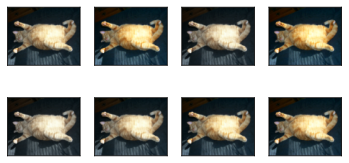

In [9]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0.5, hue=0
))

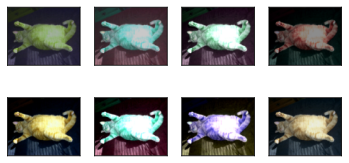

In [10]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
)
apply(img, color_aug)

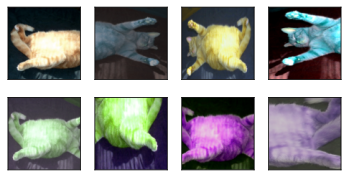

In [11]:
# 我们可以通过使用一个 Compose 实例来综合上面定义的不同的图像增广方法，并将它们应用到每个图像
augs = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug]
)
apply(img, augs)

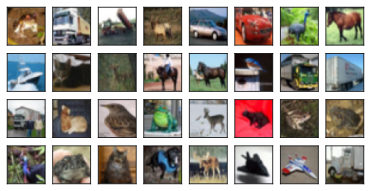

In [12]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data", download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [13]:
# 为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，且在预测过程中不使用随机操作的图像增广。
# 本次训练仅使用随机左右翻转的图像增广
# 此外，使用ToTensor实例将一批图像转换为深度学习框架所要求的格式，即形状为（批量大小，通道数，高度，宽度）的32位浮点数，取值范围为0～1
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [14]:
# 定义一个辅助函数，便于读取图像和应用图像增广
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(
        root="../data", train=is_train, download=True, transform=augs)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train,
        num_workers=d2l.get_dataloader_workers()
    )
    return dataloader

In [15]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.171, train acc 0.941, test acc 0.836
1694.6 examples/sec on [device(type='mps', index=0)]


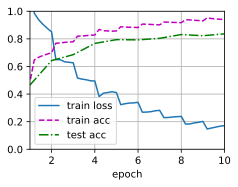

In [16]:
train_with_data_aug(train_augs, test_augs, net)

In [17]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
import d2l

In [18]:
d2l.DATA_HUB["hotdog"] = (d2l.DATA_URL + "hotdog.zip",
                                         "fba480ffa8aa7e0febbb511d181409f899b9baa5")

data_dir = d2l.download_extract("hotdog")

In [19]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

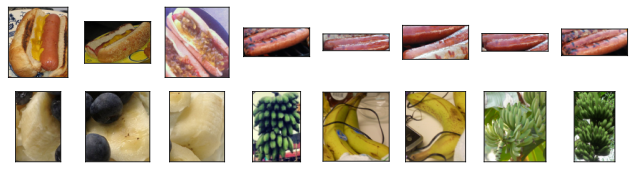

In [20]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [21]:
#在训练期间，我们首先从图像中裁切随机大小和随机长宽比的区域，然后将该区域缩放为224 ×224输入图像。
#在测试过程中，我们将图像的高度和宽度都缩放到256像素，然后裁剪中央224 ×224区域作为输入。
# 对于RGB（红、绿和蓝）颜色通道，我们分别正则化每个通道。这里预先计算并定义了这些魔数
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

In [22]:
# 下载 ImageNet 数据集上预训练的 ResNet-18 作为源模型
pretrained_net = torchvision.models.resnet18(pretrained=True)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
# 预训练的源模型实例包含许多特征层和一个输出层fc，这样可以方便微调
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [24]:
# 接下来我们设置目标模型，注意输出结果只有“是热狗”和“不是”两个区别
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

In [25]:
# 定义微调训练函数
# 如果param_group=True，输出层中的模型参数将使用十倍的学习率
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    train_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(
            os.path.join(data_dir, 'train'), transform=train_augs
        ),
        batch_size=batch_size, shuffle=True
    )
    test_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(
            os.path.join(data_dir, 'test'), transform=test_augs
        ),
        batch_size=batch_size
    )
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                    {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                    lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(
            net.parameters(), lr=learning_rate, weight_decay=1e-3
        )
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.171, train acc 0.939, test acc 0.944
516.1 examples/sec on [device(type='mps', index=0)]


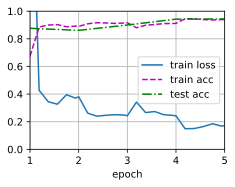

In [26]:
# 我们使用较小的学习率，通过微调预训练获得的模型参数
train_fine_tuning(finetune_net, 5e-5)

loss 0.356, train acc 0.838, test acc 0.830
609.7 examples/sec on [device(type='mps', index=0)]


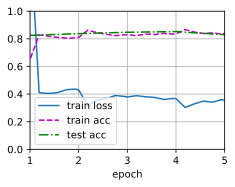

In [27]:
# 为了进行比较，我们定义了一个相同的模型，但是将其所有模型参数初始化为随机值。由于整个模型需要从头开始训练，因此我们需要使用更大的学习率。
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

In [28]:
%matplotlib inline
import torch
import d2l

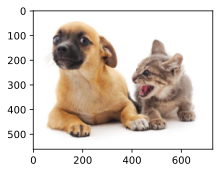

In [29]:
d2l.set_figsize()
img = d2l.plt.imread("../img/catdog.jpg")
d2l.plt.imshow(img)

In [30]:
"""
边界框有两种表示法
1. 由左上角和右下角坐标决定
2. 由边界框中心坐标及宽高决定
"""
def box_corner_to_center(boxes):
    """
    从 (左上,右下) 转换到 (中间,宽度,高度)
    """
    x1, y1, x2, y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    cx = (x1+x2)/2
    cy = (y1+y2)/2
    w = x2-x1
    h = y2-y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes


def box_center_to_corner(boxes):
    """
    从(中间,宽度,高度) 转换到 (左上,右下)
    """
    cx, cy, w, h = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    x1 = cx - w/2
    y1 = cy - h/2
    x2 = cx + w/2
    y2 = cy + h/2
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [31]:
%matplotlib inline
import torch
import d2l

torch.set_printoptions(2) # 精简输出精度

In [32]:
def multibox_prior(data, sizes, ratios):
    """
    生成以每个像素为中心具有不同形状的锚框
    :param data: 二维特征图，代码中会根据其高度和宽度来确定锚框的生成范围
    :param sizes: 一个列表，包含了锚框的不同尺度的大小，取值范围为(0,1]
    :param ratios: 一个列表，包含了锚框的不同宽高比。
    """
    #data.shape 分别为(高,宽,通道数)
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    """
    为了将锚点移动到像素的中心，需要设置偏移量
    因为一个像素的高为1且宽为1，我们选择偏移我们的中心0.5
    """
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height # 在 y 轴上缩放步长
    steps_w = 1.0 / in_width # 在 x 轴上缩放步长

    # 生成锚框的所有中心点
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    # meshgrid 将两个一维向量 h,w 张成两个 len(h)*len(w) 的二维张量
    # 其中 shift_y 第 i 行的元素均为 h[i]，shift_x 第 i 行的元素均为 w[i]
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    # 在行方向上展开二维张量
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    """
    生成 "boxes_per_pixel" 个宽和高
    之后用于创建锚框的四角坐标(xmin, xmax, ymin, ymax)
    """
    w_0 = torch.cat((sizes[0] * torch.sqrt(in_height * ratio_tensor[:] / in_width),
                     size_tensor[1:] * torch.sqrt(in_height * ratio_tensor[0] / in_width)))
    h_0 = torch.cat((sizes[0] * torch.sqrt(in_width / ratio_tensor[:] / in_height),
                     size_tensor[1:] * torch.sqrt(in_width / ratio_tensor[0] / in_height)))
    # 除以2来获得半高和半宽
    anchor_manipulations = torch.stack((-w_0, -h_0, w_0, h_0)).T.repeat(
        in_height * in_width, 1
    )/2

    """
    每个中心点都将有 "boxes_per_pixel" 个锚框
    所以生成含有所有锚框中心的网络，重复了 "boxes_per_pixel" 次
    """
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(
        boxes_per_pixel, dim=0
    )
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [33]:
img = d2l.plt.imread('../img/catdog.jpg')
h,w = img.shape[:2]
print(h,w)
X = torch.rand(size=(1,3,h,w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


torch.Size([1, 2042040, 4])

In [34]:
# 我们访问以(250,250)为中心的第一个锚框。它有四个元素：
# 左上角(x,y)和右下角(x,y)
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.01, 0.02, 0.67, 0.87])

In [35]:
# 定义 show_bboxes 函数来在图像上绘制多个边界框
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va="center", ha="center", fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

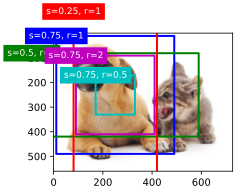

In [36]:
# 如上面结果所示，变量 boxes 中 x 轴和 y 轴的坐标值已经分别除以图像的宽度和高度
# 因此在绘制锚框时，我们需要恢复它们原始的坐标值。
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2', 's=0.75, r=0.5'])

In [37]:
# 两个边框的交并比
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    # 计算矩形面积。两集并的面积等于其面积之和减去其交的面积
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0] * (boxes[:, 3] - boxes[:, 1])))

    area1 = box_area(boxes1)
    area2 = box_area(boxes2)
    """
    在PyTorch中，None用于在指定位置插入一个新的维度。这里在第二个维度上插入一个新维度，
    使得 boxes1 的形状从 (N, 4) 变为 (N, 1, 4)

    当执行 torch.max(boxes1[:, None, :2], boxes2[:, :2])时，PyTorch就会使用广播机制。
    由于 boxes1[:, None, :2]的形状是(N, 1, 2)，boxes2[:,:2]的形状是(M,2)，广播后它们的
    形状会变为(N, M, 2)。
    这样就可以实现 boxes1 中的每个框与 boxes2 中的每个框两两组合，逐元素取最大值，从而得到每对
    框交集区域的左上角坐标
    """
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # inter_areasandunion_areas的形状：(boxes1的数量,boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = area1[:, None] + area2 - inter_areas
    return inter_areas / union_areas

In [38]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边框分配给锚框"""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于第 i 行和第 j 列第元素 x_ij 是锚框 i 和 真实边界框 j 的 IoU
    jaccard = box_iou(anchors, ground_truth)
    # 对于每个锚框，分配的真实边界框的张量
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device=device)

    # 根据阈值，决定是否分配真实边界框
    max_ious, indices = torch.max(jaccard, dim=1) # 对列求最大值
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,),-1)
    row_discard = torch.full((num_gt_boxes,),-1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard

    return anchors_bbox_map

In [39]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], dim=1)
    return offset

In [40]:
# 如果一个锚框没有被分配真实边界框，我们只需将锚框的类别标记为背景（background）。
# 背景类别的锚框通常被称为负类锚框，其余的被称为正类锚框。
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框"""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device
        )
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
        # 将类标签和分配的边界框坐标初始化为零
        class_labels = torch.zeros(num_anchors, dtype=torch.long, device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)
        # 使用真实边界框来标记锚框的类别
        # 如果一个锚框没有被分配，标记其为背景(值为零)
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 偏移量转换
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    batch_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return bbox_offset, batch_mask, class_labels

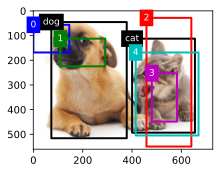

In [41]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                            [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                        [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                        [0.57, 0.3, 0.92, 0.9]])


fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4'])

In [42]:
# 计算 IoU
labels = multibox_target(anchors.unsqueeze(dim=0),
                        ground_truth.unsqueeze(dim=0))

In [43]:
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框"""
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

In [44]:
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序"""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = [] # 保留预测边界框的指标
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                    boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
        return torch.tensor(keep, device=boxes.device)

In [45]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]

        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                                conf.unsqueeze(1),
                                predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

In [46]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                        [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4, # 背景的预测概率
                        [0.9, 0.8, 0.7, 0.1], # 狗的预测概率
                        [0.1, 0.2, 0.3, 0.9]]) # 猫的预测概率

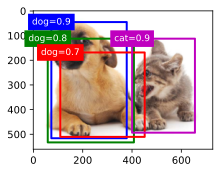

In [47]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9','dog=0.8','dog=0.7','cat=0.9'])

In [48]:
# 现在调用 multibox_detection函数来执行非极大值抑制，其中阈值设置为0.5
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)

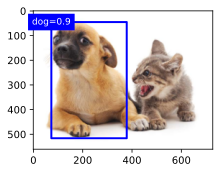

In [49]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

In [50]:
%matplotlib inline
import torch
import d2l

img = d2l.plt.imread('../img/catdog.jpg')
h, w = img.shape[:2]
h, w

(561, 728)

In [51]:
def display_anchors(fmap_w, fmap_h, s):
    """
    我们在特征图(fmap)上生成锚框(anchors)，每个单位（像素）作为锚框的中心
    对像素均匀采样 fmap_w * fmap_h 个点，并生成大小为 s 且宽高比(ratios)不同的锚框
    """
    d2l.set_figsize()
    # 前两个维度上的值不影响输出
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = d2l.multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes,
                    anchors[0] * bbox_scale)

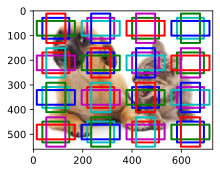

In [52]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

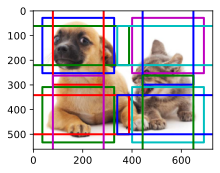

In [53]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

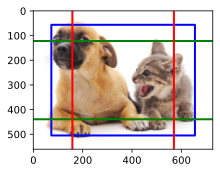

In [54]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

In [55]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
import d2l

In [56]:
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [57]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                            else 'bananas_val','label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                        'bananas_val', 'images', f'{img_name}')))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [58]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
        is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [59]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                            batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                            batch_size)
    return train_iter, val_iter

In [60]:
"""
图像的小批量的形状为(批量大小,通道数,高度,宽度)
标签的小批量的形状为(批量大小,m,5)
其中 m 是数据集中任何图像的边界框可能出现的最大数量。如果一个图像边界框不足 m，将会被非法边界框填充
这样，每个边界框的标签将被长度为5的数组表示。其中第一个元素是边界框中对象的类别，其中-1用于表示填充的非法边界框
剩下四个元素分别是边界框左上角和右下角的(x,y)坐标值（值域在0～1之间）
"""
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

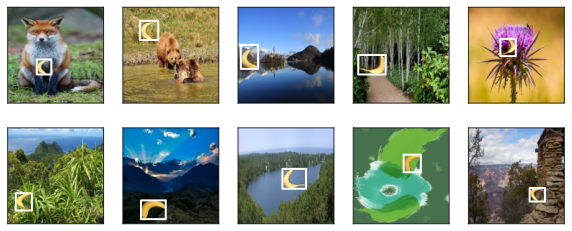

In [61]:
# permute 将
"""batch是一个打包，batch[0]是图像，batch[1]是对应的labels
图像的size一般是(批量数,通道数,高,宽)
而matplotlib接受(高,宽,通道数)，因此使用permutr调整图片各维度"""
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

In [62]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import d2l


def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                    kernel_size=3, padding=1)

In [63]:
# 边界框预测层的设计与类别预测层的设计类似。唯一不同的是，这里需要为每个锚框预测4个偏移量，而不是q + 1个类别。
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

In [64]:
# 单发多框检测使用多尺度特征图来生成锚框并预测其类别和偏移量
# 在不同尺度下，特征图的形状可能有所不同。因此，预测输出的情状也可能会有所不同

"""
下面示例中，我们为同一个小批量构建两个不同比例(Y1和Y2)的特征图，其中Y2的高度和宽度是Y1的一半
假设Y1和Y2的每个单元生成5个和3个锚框，进一步假设目标类别的数量为10
对于Y1和Y2，类别预测输出的通道数为 55 和 33，输出形状为(批量大小,通道数,高度,宽度)
"""
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [65]:
"""
正如我们所看到的，除了批量大小这一维度外，其他三个维度都具有不同的尺寸。
为了将这两个预测输出链接起来以提高计算效率，我们将把这些张量转换为更一致的格式。

通道维包含中心相同的锚框的预测结果。我们首先将通道维移到最后一维。
因为不同尺度下批量大小仍保持不变，我们可以将预测结果转成二维的（批量大小，高×宽×通道数）的格式，以方便之后在维度1上的连结。
"""
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [66]:
print("Y1:",flatten_pred(Y1).shape)
print("Y2:",flatten_pred(Y2).shape)
print("[Y1, Y2]:",concat_preds([Y1, Y2]).shape)

Y1: torch.Size([2, 22000])
Y2: torch.Size([2, 3300])
[Y1, Y2]: torch.Size([2, 25300])


In [67]:
"""
为了在多个尺度下检测目标，我们在下面定义了高和宽减半块down_sample_blk，该模块将输入特征图的高度和宽度减半。
更具体地说，每个高和宽减半块由两个填充为1的3*3的卷积层、以及步幅为2的2*2最大汇聚层组成。
"""
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                    kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [68]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

In [69]:
# 多尺度检测的基本网络块用于从输入图像中抽取特征。
# 为了计算简洁，该网络串联3个高宽减半块，并逐步将通道数翻倍
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

In [70]:
"""
完整的单发多框检测模型由五个模块组成。除了最开始的基本模块，第二个到第四个是高和宽减半块，最后一个模块使用全局最大池讲高度和宽度都降到1
"""
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [71]:
"""
不同于图像分类问题，图像检测的输出包括：CNN特征图y；当前尺度下根据y生成的锚框；预测的这些锚框的类别和偏移量（基于Y）
"""
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [72]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [73]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 即赋值语句self.blk_i=get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))


    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self,'blk_%d'%i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
                            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [74]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)
"""
第一个模块输出特征图的形状为32*32，后面每个模块减半，最后一个模块为全局汇聚层
对特征图的每个单元为中心有4个锚框生成，因此在所有五个尺度下，每个图像共生成
sum(i ** 2 for i in [32, 16, 8, 4, 1]) * 4 = 5444个锚框
"""
print('output anchors:', anchors.shape)
# shape: [batch_size, num_channels, classes]
print('output class preds:', cls_preds.shape)
# shape: [batch_size, offsets(5444*4))
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


In [75]:
# 读取香蕉检测数据集
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [76]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

In [77]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
# 对偏移量使用L1范数损失
bbox_loss = nn.L1Loss(reduction='none')

# 掩码变量bbox_masks令负类锚框和填充锚框不参与损失的计算。
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                    cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                    bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [78]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    return float((cls_preds.argmax(dim=-1).type(
                  cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

class err 3.24e-03, bbox mae 3.17e-03
11778.3 examples/sec on mps:0


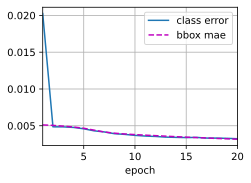

In [79]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error','bbox mae'])
net = net.to(device)


for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                        bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                    bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                    bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
        f'{str(device)}')

In [80]:
"""
unsequeeze(input, dim)为在dim处添加一个维度，维度大小为1
例如
X = torch.randn(3,4)
Y = torch.unsqueeze(X,dim=0)
Y.shape
输出为
torch.Size([1, 3, 4])
"""
X = torchvision.io.read_image('../img/banana.jpg').unsqueeze(0).float()
"""
squeeze(input, dim=None) 与 unsqueeze 正好相反，它用于移除大小为1的指定维度
若不指定，将移除所有大小为1的维度
"""
img = X.squeeze(0).permute(1, 2, 0).long()

In [81]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    # 通过非极大值抑制来移除相似的预测边界框
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

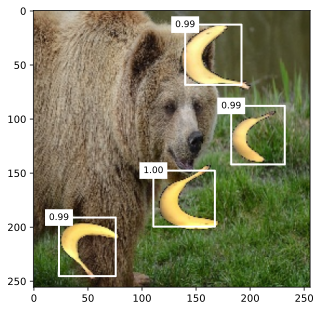

In [82]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')


display(img, output.cpu(), threshold=0.9)

In [83]:
import torch
import torchvision

# 兴趣区域汇聚层
# 设特征窗口为4*4
X = torch.arange(16.).reshape(1,1,4,4)

In [84]:
# 生成两个提议区域。每个提议区域由5个元素表示：区域目标类别、左上角和右下角的(x,y)坐标
rois = torch.Tensor([[0, 0, 0, 20, 20], [0, 0, 10, 30, 30]])

"""
假设输入图像的为40*40，这样图像和特征窗口的spatial_scale=0.1
先将rois按照spatial_scale相乘，然后在X上分别标出两个兴趣区域
X[:,:,0:3,0:3] 和 X[:,:,1:4,0:4]
最后，在2*2的兴趣区域汇聚层中，每个兴趣区域被划分为子窗口网络，并进一步抽取相同形状2*2特征
"""
torchvision.ops.roi_pool(X, rois, output_size=(2,2), spatial_scale=0.1)

tensor([[[[ 5.,  6.],
          [ 9., 10.]]],


        [[[ 9., 11.],
          [13., 15.]]]])

In [85]:
%matplotlib inline
import os
import torch
import torchvision
import d2l

In [86]:
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                            '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')
voc_dir = d2l.download_extract('voc2012','VOCdevkit/VOC2012')

In [87]:
def read_voc_images(voc_dir, is_train=True):
    """读取所有VOC图像并标注"""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                            'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
                voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(
                voc_dir, 'SegmentationClass', f'{fname}.png'), mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

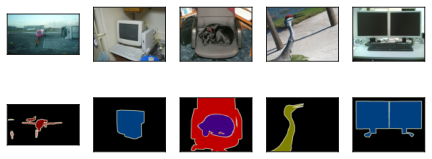

In [88]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
imgs = [img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs, 2, n);

In [89]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
[0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
[64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
[64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
[0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
[0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'diningtable',
               'dog', 'horse', 'motorbike', 'cow', 'person', 'potted plant',
               'sheep', 'sofa', 'train', 'tv/monitor']

In [90]:
def voc_colormap2label():
    """构建从RGB到VOC类别索引的映射"""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

def voc_label_indices(colormap, colormap2label):
    """将VOC标签中的RGB值映射到它们的类别索引"""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
    + colormap[:, :, 2])
    return colormap2label[idx]

In [91]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

In [92]:
def voc_rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像"""
    rect = torchvision.transforms.RandomCrop.get_params(
                    feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

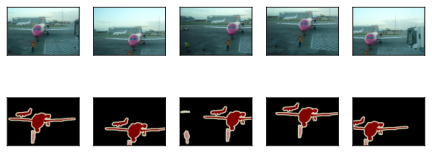

In [93]:
imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

In [94]:
class VOCSegDataset(torch.utils.data.Dataset):
    """一个用于加载VOC数据集的自定义数据集"""

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                        for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                        *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [95]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [96]:
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
    'VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter

In [97]:
import torch
from torch import nn
import d2l

In [98]:
# 转置矩阵
def trans_conv(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i: i + h, j: j + w] += X[i, j] * K
    return Y

In [99]:
X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
trans_conv(X, K)

tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])

In [100]:
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[ 0.,  0.,  1.],
          [ 0.,  4.,  6.],
          [ 4., 12.,  9.]]]], grad_fn=<ConvolutionBackward0>)

In [101]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, padding=1, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[4.]]]], grad_fn=<ConvolutionBackward0>)

In [102]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[0., 0., 0., 1.],
          [0., 0., 2., 3.],
          [0., 2., 0., 3.],
          [4., 6., 6., 9.]]]], grad_fn=<ConvolutionBackward0>)

In [103]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F

import importlib
import d2l
importlib.reload(d2l)

<module 'd2l' from '/Users/yangzejia/PycharmProjects/DeepLearningLearn/d2l/__init__.py'>

In [104]:
# 使用ImageNet数据集上预训练的ResNet-18模型来提取图像特征
# 并将该网络记为 pretrained_net
# ResNet-18模型的最后几层包括全局平均汇聚层和全连接层，但全卷积网络中不需要它们
pretrained_net = torchvision.models.resnet18(weights=True)
list(pretrained_net.children())[-3:]
test = torchvision.models.resnet50(pretrained=True)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weig

In [105]:
# 我们的全卷积网络复制除最后的全局平均汇聚层和最接近输出的全连接层
net = nn.Sequential(*list(pretrained_net.children())[:-2])

In [106]:
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

In [107]:
"""
接下来使用1*1卷积层将输出通道数转换为Pascal VOC2012数据集的类数（21类）。
最后需要将特征图的高度和宽度增加32倍，从而将其变回输入图像的高和宽。
"""
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

In [108]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [109]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

In [110]:
img = torchvision.transforms.ToTensor()(d2l.Image.open('../img/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


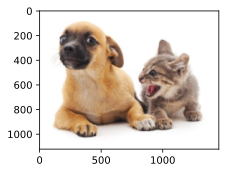

In [111]:
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0));
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img)

In [112]:
# 用双线性插值的上采样初始化转置卷积层。对于 1*1 卷积层，我们使用Xavier初始化参数。
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

In [113]:
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


In [114]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

loss 0.422, train acc 0.868, test acc 0.852
73.7 examples/sec on [device(type='mps', index=0)]


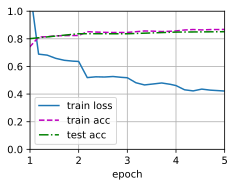

In [115]:
num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [116]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

In [117]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

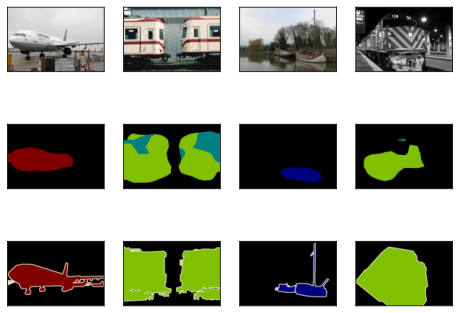

In [118]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
            torchvision.transforms.functional.crop(
                test_labels[i], *crop_rect).permute(1,2,0)]

d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

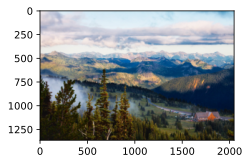

In [119]:
%matplotlib inline
import torch
import torchvision
from torch import nn
import d2l

d2l.set_figsize()
content_img = d2l.Image.open('../img/rainier.jpg')
d2l.plt.imshow(content_img);

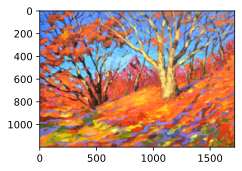

In [120]:
style_img = d2l.Image.open('../img/autumn-oak.jpg')
d2l.plt.imshow(style_img);

In [121]:
# rgb 图像的统计学特征，用于 preprocess 图像做标准化
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

In [122]:
def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std),
    ])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    # clamp 函数将数值截断在[0,1]内
    img = torch.clamp(img.permute(1,2,0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2,0,1))

In [123]:
import torchvision
import ssl
import certifi

# 指定 certifi 证书路径
ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())

# 使用 ImageNet 数据集预训练的 VGG-19 模型来抽取图像特征
pretrained_net = torchvision.models.vgg19(weights=True)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [124]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [125]:
# 使用VGG层抽取特征时，我们只需要用到从输入层到最靠近输出层的内容层或风格层之间的所有层。
# 下面构建一个新的网络net，它只保留需要用到的VGG的所有层。
net = nn.Sequential(*[pretrained_net.features[i] for i in
    range(max(content_layers + style_layers) + 1)])

In [126]:
range(max(content_layers + style_layers) + 1)

range(0, 29)

In [127]:
# 给定输入X，如果我们简单地调用前向传播 net(X)，只能获得最后一层的输出
# 由于我们还需要中间层的输出，因此这里我们逐层计算，并保留内容层和风格层的输出

def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []

    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [128]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    content_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, content_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, style_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, style_Y

In [129]:
def content_loss(Y_hat, Y):
    return torch.square(Y_hat - Y.detach()).mean()

In [130]:
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

In [131]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

In [132]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
            torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [133]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
                contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
                styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [134]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [135]:
def get_inits(X, device, lr, styles_Y):
    """
    该函数创建了合成图像的模型实例，并将其初始化为图像X。
    风格图像在各个风格层的格拉姆矩阵styles_Y_gram将在训练前预先计算好。
    """
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [136]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers
        )
        contents_l, style_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram
        )
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1,
                         [float(sum(contents_l)), float(sum(style_l)), float(tv_l)])
    return X

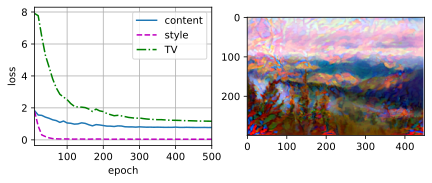

In [137]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
# 首先使用内容图像来初始化合成图像
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

In [138]:
content_weight, style_weight, tv_weight = 1, 4e3, 12

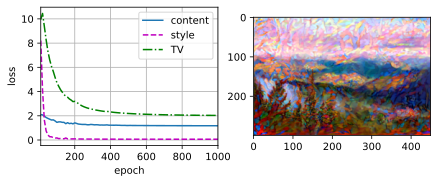

In [139]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
# 首先使用内容图像来初始化合成图像
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 1000, 50)

In [140]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
import d2l

In [141]:
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')
# 如果使用完整的Kaggle竞赛的数据集，设置demo为False
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

In [142]:
def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# 训练样本 :', len(labels))
print('# 类别 :', len(set(labels.values())))

# 训练样本 : 1000
# 类别 : 10


In [143]:
def copyfile(filename, target_dir):
    """将文件复制到目标目录"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)


def reorg_train_valid(data_dir, labels, valid_ratio):
    """将验证集从原始的训练集中拆分出来"""
    # 训练数据集中样本最少的类别中的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 验证集中每个类别的样本数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
            'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                        'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                        'train', label))

    return n_valid_per_label

In [144]:
def reorg_test(data_dir):
    """在预测期间整理测试集，以方便读取"""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                os.path.join(data_dir, 'train_valid_test', 'test','unknown'))

In [145]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

In [146]:
batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

In [147]:
transform_train = torchvision.transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    torchvision.transforms.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64～1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                 ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
    [0.2023, 0.1994, 0.2010])]
)

In [148]:
# 测试期间，我们只对图像执行标准化，以消除评估结果中的随机性
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
    [0.2023, 0.1994, 0.2010])]
)

In [149]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train','train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid','test']]

In [150]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                        drop_last=True)
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

In [151]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")

In [152]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
            lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                                weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                            (metric[0] / metric[2], metric[1] / metric[2],
                            None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f},'
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
            f' examples/sec on {str(devices)}')

train loss 0.580,train acc 0.809, valid acc 0.391
1653.4 examples/sec on [device(type='mps', index=0)]


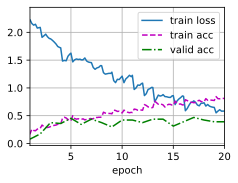

In [153]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
        lr_decay)

In [154]:
import os
import torch
import torchvision
from torch import nn
import d2l

In [155]:
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip',
                            '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

# 如果使用Kaggle比赛的完整数据集，请将下面的变量更改为False
demo = True
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')

In [156]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)


batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

In [157]:
transform_train = torchvision.transforms.Compose([
    # 随机裁剪图像，所得图像为原始面积的0.08～1之间，高宽比在3/4和4/3之间。
    # 然后，缩放图像以创建224x224的新图像
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                            ratio=(3.0/4.0, 4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    # 随机更改亮度，对比度和饱和度
    torchvision.transforms.ColorJitter(brightness=0.4,
                                        contrast=0.4,
                                        saturation=0.4),
    # 添加随机噪声
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])])

In [158]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    # 从图像中心裁切224x224大小的图片
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])]
)

In [159]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train','train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid','test']]

In [160]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                        drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

In [161]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    # 定义一个新的输出网络，共有120个输出类别
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 120))
    # 将模型参数分配给用于计算的CPU或GPU
    finetune_net = finetune_net.to(devices[0])
    # 冻结参数
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

In [162]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return (l_sum / n).to('cpu')

In [163]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    # 只训练小型自定义输出网络
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD((param for param in net.parameters()
                               if param.requires_grad), lr=lr,
                              momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 1.032, valid loss 1.264
1156.7 examples/sec on [device(type='mps', index=0)]


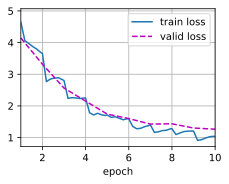

In [164]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)